In [39]:
import numpy as np
from os import listdir
from os.path import isfile, join

mypath = "./fittings_switch_1/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

import yaml


In [40]:
all_results = []
for folder in onlyfiles:
    if 'fit' in folder:
        with open(mypath+folder) as file:
            r = yaml.load(file, Loader=yaml.UnsafeLoader)
            r['replicating_v'] = [r['days_ahead']]+r['result']+[r['days_switch']]
            all_results.append(r)

In [41]:
best_error_i = np.argmin([r['value'] for r in all_results])
print(all_results[best_error_i])

{'days_ahead': 86, 'days_switch': 15, 'iterations': 50, 'n_samples': 1, 'result': [4.0, 1.1500674843132932, 0.9167464969507519, 0.3172592009287859, 0.05127780756604089, 0.5485413278685041, 0.09666047198529543, 0.9641282174235299, 1.3385486523912138, 0.5, 2.0, 1.2403213647998759], 'value': 5.820766681165322, 'replicating_v': [86, 4.0, 1.1500674843132932, 0.9167464969507519, 0.3172592009287859, 0.05127780756604089, 0.5485413278685041, 0.09666047198529543, 0.9641282174235299, 1.3385486523912138, 0.5, 2.0, 1.2403213647998759, 15]}


In [58]:
best = []
for r in all_results:
    if r['value']<6.0:
        best.append(r)
        print("value",r['value'],"alpha:",r['result'][0],"mix:",r['result'][2])

value 5.820766681165322 alpha: 4.0 mix: 0.9167464969507519
value 5.978724008458988 alpha: 3.1265445211444125 mix: 1.0
value 5.976088901798663 alpha: 2.3349136236108903 mix: 0.0
value 5.886196359849379 alpha: 1.2591542316357165 mix: 0.08961006723290153


In [53]:
# In[57]:
b = best[2]
days_ahead_opt = b['days_ahead']
days_switch_opt = b['days_switch']
v= b['result']
print("days_ahead",days_ahead_opt)
print("days_switch",days_switch_opt)
n_samples = 1
maxiter = 50
icu_bound = 2950

days_ahead 88
days_switch 50


/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: UserWarning: Boolean Series key will be reindexed t

0.7791072263244828
7.194862933913178


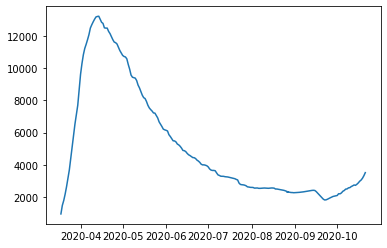

In [54]:
import pandas as pd
from datetime import datetime, timedelta
import numpy


# In[2]:


import numpy as np
import pandas as pd







# In[4]:


lower_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_lower")
upper_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_upper")


# In[5]:


age_groups = ['age_group_0_9', 'age_group_10_19', 'age_group_20_29','age_group_30_39', 'age_group_40_49', 'age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
old_age_groups = ['age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
econ_activities = ['transport', 'leisure', 'other']
cont = [ 'S', 'E', 'I', 'R', 'N', 'Ia', 'Ips',            'Ims', 'Iss', 'Rq', 'H', 'ICU', 'D' ]


# In[6]:


data = pd.read_csv("donnees-hospitalieres-classe-age-covid19-2020-10-28-19h00.csv", sep=";")
data.head()


# In[7]:


google = pd.read_csv("2020_FR_Region_Mobility_Report.csv")
google = google[google['sub_region_1']=="Île-de-France"]
google = google[pd.isnull(google['sub_region_2'])]


# In[8]:


initial_work = ((google["workplaces_percent_change_from_baseline"]+100)/100).values
google_days = [datetime.strptime(google["date"].values[i], '%Y-%m-%d').weekday() for i in range(len(google["date"]))]
new_work = []
for i in range(len(initial_work)):
    if google_days[i]<=4:
        new_work.append(initial_work[i])
    elif google_days[i]==5:
        numbers_for_mean = []
        for k in range(i-5,i):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        for k in range(i+2,i+7):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        new_work.append(np.mean(numbers_for_mean))
    elif google_days[i]==6:
        numbers_for_mean = []
        for k in range(i-6,i-1):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        for k in range(i+1,i+6):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        new_work.append(np.mean(numbers_for_mean))


# In[9]:


google['work'] = new_work
google['transport'] = (google["transit_stations_percent_change_from_baseline"]+100)/100
google['other'] = 0.33*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+0.67*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
google['leisure'] = 0.33*(google["parks_percent_change_from_baseline"]+100)/100+0.67*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100
google = google.reset_index()
google.to_csv('smoothed.csv')


# In[10]:


# Extract days 
data = data[data['jour']<='2020-10-21']
days = data[data['reg']==11][data['cl_age90']==0].jour.values


# In[11]:


data


# In[12]:


beds_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].hosp.values for i in range(0,9)
}
beds_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].hosp.values
beds_real['total']=data[data['reg']==11][data['cl_age90']==0].hosp.values

icus_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].rea.values for i in range(0,9)
}
icus_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].rea.values
icus_real['total']=data[data['reg']==11][data['cl_age90']==0].rea.values

deaths_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].dc.values for i in range(0,9)
}
deaths_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].dc.values
deaths_real['total']=data[data['reg']==11][data['cl_age90']==0].dc.values


# In[13]:


import yaml
from inspect import getsourcefile
import os.path
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import argparse
current_path = os.path.abspath(getsourcefile(lambda:0))
current_dir = os.path.dirname(current_path)
parentdir = os.path.dirname(current_dir)
sys.path.insert(0,parentdir) 
sys.path.insert(0, parentdir+"/heuristics")
sys.path.insert(0, parentdir+"/heuristics/LP-Models")
sys.path.insert(0, parentdir+"/fast_gradient")


from fast_group import FastDynamicalModel
from aux import *



# In[14]:


start_smooth = datetime.strptime("2020-09-01", '%Y-%m-%d')
end_smooth = datetime.strptime("2020-10-01", '%Y-%m-%d')
for ag in beds_real:
    new_series = []
    for i in range(len(beds_real[ag])):
        day = datetime.strptime(days[i], '%Y-%m-%d')
        lower = (day-start_smooth).days
        upper = (end_smooth-day).days
        if lower>=0 and upper>=0:
            n_days_before = min(lower,3)
            n_days_after = min(upper,3)
            avg_value = np.mean(beds_real[ag][(i-n_days_before):(i+1+n_days_after)])
            new_series.append(avg_value)
        else:
            new_series.append(beds_real[ag][i])
    beds_real[ag] = np.array(new_series)
        


# In[15]:



plt.figure(1)
plt.plot([datetime.strptime(d, '%Y-%m-%d') for d in days],beds_real["total"])


# In[16]:


mult_deaths = np.sum(data[data['reg']==11][data['cl_age90']==0].hosp.values)/np.sum(data[data['reg']==11][data['cl_age90']==0].dc.values)
print(mult_deaths)
mult_icus = np.sum(data[data['reg']==11][data['cl_age90']==0].hosp.values)/np.sum(data[data['reg']==11][data['cl_age90']==0].rea.values)
print(mult_icus)


# In[17]:


region = "Ile-de-France"


# In[18]:


# Read group parameters
with open("../parameters/"+region+".yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)
    
# Read initialization
with open("../initialization/patient_zero.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    original_initialization = yaml.load(file, Loader=yaml.FullLoader)

# Read econ parameters
with open("../parameters/econ.yaml") as file:
    econ_params = yaml.load(file, Loader=yaml.FullLoader)

experiment_params = {
    'delta_schooling':0.5,
    'xi':0,
    'icus':3000,
}


# In[19]:


date_1 = datetime.strptime("2020-03-17", '%Y-%m-%d')
date_2 = datetime.strptime("2020-05-11", '%Y-%m-%d')
date_3 = datetime.strptime("2020-06-01", '%Y-%m-%d')
date_4 = datetime.strptime("2020-07-01", '%Y-%m-%d')
date_5 = datetime.strptime("2020-09-01", '%Y-%m-%d')
final_date = datetime.strptime("2020-10-21", '%Y-%m-%d')

vacation_start = datetime.strptime("2020-04-01", '%Y-%m-%d')
vacation_end = date_5
days_vacation_start = (vacation_start - date_1).days
days_vacation_end = (vacation_end - date_1).days

first_day_google = datetime.strptime("2020-02-15", '%Y-%m-%d')
days_between_google = (date_1-first_day_google).days


# In[20]:


(final_date-date_1).days+140


# In[21]:


from copy import deepcopy


# In[22]:


original_beta = universe_params['seir-groups']["age_group_0_9"]["parameters"]["beta"]
original_beta_vacation = original_beta
#original_beta_vacation = universe_params['seir-groups']["age_group_0_9"]["parameters"]["beta_vacation"]
t_days_beta = 730

for ag in universe_params['seir-groups']:
    universe_params['seir-groups'][ag]["parameters"]["beta"] = (
        [(original_beta if (t<days_vacation_start or t>= days_vacation_end) else original_beta_vacation) for t in range(t_days_beta) ]
    )


# In[23]:


# Create model
mixing_method = {}
dynModel = FastDynamicalModel(universe_params, econ_params, experiment_params, 1, mixing_method, 1e9, 0, 0)


# In[24]:


params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params", index_col = 0)
initial_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values,
    "lambda_ICU":params['lambda_ICU'].values,
    "lambda_H":params['lambda_H'].values,
    "p_death":params['p_death_cond_ss'].values,
    "p_recov":params['p_recov_cond_ss'].values,
    
}

params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_lower", index_col = 0)
lower_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}

params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_upper", index_col = 0)
upper_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}


# In[25]:


# Construct the windows for the parameters to move

windows = {}
windows['beta_mixing'] = (0.1,2.0)
windows['alpha_mixing'] = (0.1,4.0)
windows['gamma_mixing'] = (0.5,2.0)
windows['work_l'] = (0.2,0.3)
windows['other_l'] = (0,0.1)
windows['school_l'] = (0,0.1)
windows['leisure_l'] = (0,0.1)
windows['transport_l'] = (0.2,0.3)
windows['transmission'] = (0.5,2.0)


# In[26]:


# Generate samples
np.random.seed(0)
samples = 1+np.random.randn(n_samples,(final_date-date_1).days+150, 5)*0.05/2/np.sqrt(3)


# In[47]:


import copy
import math
import matplotlib.dates as mdates
best_v = 0
best_error = float('inf')
validation_date = datetime.strptime("2020-10-21", '%Y-%m-%d')


def error_function(v,n_sample):
    days_ahead = days_ahead_opt
    alpha_mixing_home = v[0]
    alpha_mixing_work = v[0]
    alpha_mixing_transport = v[0]
    alpha_mixing_school = v[0]
    alpha_mixing_other = v[0]
    alpha_mixing_leisure = v[0]
    
    mix_1 = v[2]
    mix_2 = v[3]
    
    alphas_d = {
        'work':alpha_mixing_work,
        'transport':alpha_mixing_transport,
        'school':alpha_mixing_school,
        'other':alpha_mixing_other,
        'leisure':alpha_mixing_leisure,
        'home':alpha_mixing_home,
    }

    gamma_mixing_before = 1.0
    gamma_mixing_after = 1.0


    upper_bound_home = 1.0
    upper_bound_leisure = 1.0
    upper_bound_other = 1.0
    upper_bound_school = 1.0
    upper_bound_work = 1.0
    upper_bound_transport = 1.0

    school_lockdown = v[4]
    school_may = v[5]
    school_jun_jul_aug = v[6]
    school_sep_oct = v[7]

    beta_normal = original_beta
    beta_vacation = beta_normal*v[1]

    days_change_model = 0

    #         split_H_ICU_bef = v[9]
    #         change_lambda_H_bef = v[10]
    #         change_lambda_ICU_bef = v[11]
    #         change_p_death_bef = v[12]
    
    fraction_p_ICU = v[8]
    change_lambda_H_aft = v[9]
    change_lambda_ICU_aft = v[10]
    change_p_death_aft = v[11]
    

    
    days_change_rates = days_switch_opt
    
    #         dynModel.sigma = initial_params["sigma"]*v[10]

    #         dynModel.lambda_H_R = initial_params["lambda_H_R"]*v[13]
    
    #         dynModel.lambda_ICU_R = initial_params["lambda_ICU_R"]*v[15]




    google['other'] = mix_1*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+(1-mix_1)*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
    google['leisure'] = mix_2*(google["parks_percent_change_from_baseline"]+100)/100+(1-mix_2)*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100


    # Number of days
    days_before_date_1 = int(days_ahead)
    days_between_dates_1_2 = (date_2-date_1).days
    days_between_dates_2_3 = (date_3-date_2).days
    days_between_dates_3_4 = (date_4-date_3).days
    days_between_dates_4_5 = (date_5-date_4).days
    days_after_date_5 = (final_date-date_5).days
    total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5+ days_after_date_5
    days_denom = days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4+days_between_dates_4_5


    # Some additional calculations
    validation_days = days_before_date_1 + (validation_date-date_1).days
    vacation_start_days = days_before_date_1 + (vacation_start-date_1).days
    vacation_end_days = days_before_date_1 + (vacation_end-date_1).days


    # Construct initialization
    initialization = copy.deepcopy(original_initialization)
    for i,group in enumerate(age_groups):
        if group == "age_group_40_49":
            initialization[group]["I"] = initialization[group]["I"] + 1
            initialization[group]["S"] = initialization[group]["S"] - 1
        initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]


    # Alphas
    a_before_google = {
        'home':upper_bound_home,
        'leisure':upper_bound_leisure,
        'other':upper_bound_other,
        'school':upper_bound_school,
        'transport':upper_bound_transport,
        'work':upper_bound_work
    }



    # Determine mixing method
    #     mixing_method_before = {
    #         "name":"mult",
    #         "param_alpha":alpha_mixing_before,
    #         "param_beta":alpha_mixing_before,
    #     }

    #     # Determine mixing method
    #     mixing_method_after = {
    #         "name":"mult",
    #         "param_alpha":alpha_mixing_after,
    #         "param_beta":alpha_mixing_after,
    #     }
    #dynModel.mixing_method = mixing_method_after




    # Calculate alphas
    alphas_vec = []
    for t in range(days_before_date_1-days_between_google):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_before_google
        alphas_vec.append(alphas)

    counter = 0
    for t in range(days_between_google):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = {
                'home':1.0,
                'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                'other':google['other'][counter]*samples[n_sample,counter,1],
                'school':1.0,
                'transport':google['transport'][counter]*samples[n_sample,counter,3],
                'work':google['work'][counter]*samples[n_sample,counter,4],
            }
        alphas_vec.append(alphas)   
        counter += 1
    for t in range(days_between_dates_1_2):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = {
                'home':1.0,
                'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                'other':google['other'][counter]*samples[n_sample,counter,1],
                'school':school_lockdown*samples[n_sample,counter,2],
                'transport':google['transport'][counter]*samples[n_sample,counter,3],
                'work':google['work'][counter]*samples[n_sample,counter,4],
            }
        alphas_vec.append(alphas)   
        counter += 1
    for t in range(days_between_dates_2_3):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = {
                'home':1.0,
                'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                'other':google['other'][counter]*samples[n_sample,counter,1],
                'school':school_may*samples[n_sample,counter,2],
                'transport':google['transport'][counter]*samples[n_sample,counter,3],
                'work':google['work'][counter]*samples[n_sample,counter,4],
            }
        alphas_vec.append(alphas)   
        counter += 1
    for t in range(days_between_dates_3_4):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = {
                'home':1.0,
                'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                'other':google['other'][counter]*samples[n_sample,counter,1],
                'school':school_may*samples[n_sample,counter,2],
                'transport':google['transport'][counter]*samples[n_sample,counter,3],
                'work':google['work'][counter]*samples[n_sample,counter,4],
            }
        alphas_vec.append(alphas)   
        counter += 1
    for t in range(days_between_dates_4_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = {
                'home':1.0,
                'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                'other':google['other'][counter]*samples[n_sample,counter,1],
                'school':school_jun_jul_aug*samples[n_sample,counter,2],
                'transport':google['transport'][counter]*samples[n_sample,counter,3],
                'work':google['work'][counter]*samples[n_sample,counter,4],
            }
        alphas_vec.append(alphas)   
        counter += 1
    for t in range(days_after_date_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = {
                'home':1.0,
                'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                'other':google['other'][counter]*samples[n_sample,counter,1],
                'school':school_sep_oct*samples[n_sample,counter,2],
                'transport':google['transport'][counter]*samples[n_sample,counter,3],
                'work':google['work'][counter]*samples[n_sample,counter,4],
            }
        alphas_vec.append(alphas)
        counter += 1




    #     mixing_vec = []
    #     for t in range(int(vacation_start_days+days_change_model)):
    #         mixing_vec.append(mixing_method_before)
    #     for t in range(int(vacation_start_days+days_change_model),total_days):
    #         mixing_vec.append(mixing_method_after)




    # Calculate tests
    tests = np.zeros(len(age_groups))


    # Run model
    model_data_beds = {ag:[] for ag in age_groups+["total"]}
    model_data_icus = {ag:[] for ag in age_groups+["total"]}
    model_data_deaths = {ag:[] for ag in age_groups+["total"]}

    state = state_to_matrix(initialization)
    t_beds = 0
    t_icus = 0
    t_deaths = 0
    for i,ag in enumerate(age_groups):
        state_H = state[i,cont.index("H")]
        state_ICU = state[i,cont.index("ICU")]
        state_D = state[i,cont.index("D")]
        model_data_beds[ag].append(state_H)
        model_data_icus[ag].append(state_ICU)
        model_data_deaths[ag].append(state_D)
        t_beds+= state_H
        t_icus+= state_ICU
        t_deaths+= state_D
    model_data_beds["total"].append(t_beds)
    model_data_icus["total"].append(t_icus)
    model_data_deaths["total"].append(t_deaths)

    recalc_days = [0,
                 days_before_date_1,
                 days_before_date_1+days_between_dates_1_2,
                 days_before_date_1+days_between_dates_1_2+days_between_dates_2_3,
                 days_before_date_1+days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4,
                 days_before_date_1+days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4+days_between_dates_4_5,
                int(vacation_start_days)
                ]

    dynModel.beta = np.zeros((len(age_groups),len(dynModel.groups[age_groups[0]].parameters["beta"])))
    for i in range(len(age_groups)):
        for j in range(len(dynModel.groups[age_groups[0]].parameters["beta"])):
            if j < int(vacation_start_days+days_change_model):
                dynModel.beta[i,j] = beta_normal
            else:
                dynModel.beta[i,j] = beta_vacation

    for t in range(total_days):
        current_date = date_1+timedelta(days=t-days_before_date_1)
        day_of_week = current_date.weekday()

        if t in recalc_days:
            update_contacts = True
        else:
            update_contacts = False
            
        if t<int(vacation_start_days+days_change_rates):
            dynModel.p_H = initial_params["p_H"]
            dynModel.p_ICU = initial_params["p_ICU"]

            lambda_H = initial_params["lambda_H"]
            lambda_ICU = initial_params["lambda_ICU"]
            p_death = initial_params["p_death"]
            
            dynModel.lambda_H_D = p_death*lambda_H
            dynModel.lambda_H_R = (1-p_death)*lambda_H
            dynModel.lambda_ICU_D = p_death*lambda_ICU
            dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU

        else:
            trans_days = 30.0
            d_after = t-int(vacation_start_days+days_change_rates)
            d_portion = max(trans_days-d_after,0)/trans_days
            
            dynModel.p_ICU = initial_params["p_H"]*d_portion+initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion)
            dynModel.p_H = initial_params["p_ICU"]*d_portion+(initial_params["p_H"]+initial_params["p_ICU"])-initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion)
            

            lambda_H = initial_params["lambda_H"]*d_portion+initial_params["lambda_H"]*change_lambda_H_aft*(1-d_portion)
            lambda_ICU = initial_params["lambda_ICU"]*d_portion+ initial_params["lambda_ICU"]*change_lambda_ICU_aft*(1-d_portion)
            p_death = initial_params["p_death"]*d_portion+initial_params["p_death"]*change_p_death_aft*(1-d_portion)
            
            dynModel.lambda_H_D = p_death*lambda_H
            dynModel.lambda_H_R = (1-p_death)*lambda_H
            dynModel.lambda_ICU_D = p_death*lambda_ICU
            dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU
        

        if day_of_week <= 4:
            season = "new"
            dynModel.mixing_method = {
                "name":"mult",
                "param_alpha":{
                    'work':alpha_mixing_work,
                    'transport':alpha_mixing_transport,
                    'school':alpha_mixing_school,
                    'other':alpha_mixing_other,
                    'leisure':alpha_mixing_leisure,
                    'home':alpha_mixing_home,
                },
                "param_beta":{
                    'work':alpha_mixing_work,
                    'transport':alpha_mixing_transport,
                    'school':alpha_mixing_school,
                    'other':alpha_mixing_other,
                    'leisure':alpha_mixing_leisure,
                    'home':alpha_mixing_home,
                },
            }
        else:
            season = "new"
            dynModel.mixing_method = {
                "name":"mult",
                "param_alpha":{
                    'work':alpha_mixing_work,
                    'transport':alpha_mixing_transport,
                    'school':alpha_mixing_school,
                    'other':alpha_mixing_other,
                    'leisure':alpha_mixing_leisure,
                    'home':alpha_mixing_home,
                },
                "param_beta":{
                    'work':alpha_mixing_work,
                    'transport':alpha_mixing_transport,
                    'school':alpha_mixing_school,
                    'other':alpha_mixing_other,
                    'leisure':alpha_mixing_leisure,
                    'home':alpha_mixing_home,
                },
            }

        #dynModel.mixing_method = mixing_vec[t]

        state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]), t, season, update_contacts=update_contacts)
        t_beds = 0
        t_icus = 0
        t_deaths = 0
        for i,ag in enumerate(age_groups):
            state_H = state[i,cont.index("H")]
            state_ICU = state[i,cont.index("ICU")]
            state_D = state[i,cont.index("D")]
            model_data_beds[ag].append(state_H)
            model_data_icus[ag].append(state_ICU)
            model_data_deaths[ag].append(state_D)
            t_beds+= state_H
            t_icus+= state_ICU
            t_deaths+= state_D
        #print(t_beds)
        model_data_beds["total"].append(t_beds)
        model_data_icus["total"].append(t_icus)
        model_data_deaths["total"].append(t_deaths)


    initial_date = date_1-timedelta(days=days_before_date_1)

    # Calculate the days of the model
    days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

    # Indices where to put the real data
    indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

    # Real data
    real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}

    for k,ind in enumerate(indices):
        for ag in age_groups+["total"]:
            real_data_beds[ag][ind] = beds_real[ag][k] if beds_real[ag][k]!=0 else float('nan')
            real_data_icus[ag][ind] = icus_real[ag][k] if icus_real[ag][k]!=0 else float('nan')
            real_data_deaths[ag][ind] = deaths_real[ag][k] if deaths_real[ag][k]!=0 else float('nan')


    error_constant = 0.25
    error_beds = 0
    error_icus = 0
    error_deaths = 0
    error_beds_total = 0
    error_icus_total = 0
    error_deaths_total = 0
    
    peak_beds = np.nanargmax(np.array(real_data_beds["total"]))
    peak_icus = np.nanargmax(np.array(real_data_icus["total"]))
    peak_deaths = peak_beds+30
    
    for ag in old_age_groups:
        error_beds += np.nanmean((np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag]))/np.array(real_data_beds[ag]))[0:validation_days-1])
        error_icus += np.nanmean((np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag]))/np.array(real_data_icus[ag]))[0:validation_days-1])
        error_deaths += np.nanmean((np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag]))/np.array(real_data_deaths[ag]))[0:validation_days-1])
    error_beds_total += np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[0:validation_days-1])
    error_beds_total += error_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[validation_days-1:validation_days])
    error_beds_total += error_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[peak_beds:peak_beds+1])
                          
    error_icus_total += np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[0:validation_days-1])
    error_icus_total += error_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[validation_days-1:validation_days])
    error_icus_total += error_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[peak_icus:peak_icus+1])

                          
    error_deaths_total += np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[0:validation_days-1])
    error_deaths_total += error_constant*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[validation_days-1:validation_days])
    error_deaths_total += error_constant/2.0*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_deaths:peak_deaths+1])
    error_deaths_total += error_constant/2.0*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_beds:peak_beds+1])

    overflow = np.array(model_data_icus["total"]) - icu_bound
    overflow_error = np.nanmean([max(overflow[i],0) for i in range(len(overflow))])



    #diff = np.array(model_data_beds["total"])-np.array(real_data_beds["total"])
    #error_beds_above = np.nanmean([max(d,0) for d in diff])
    #error_beds_below = -np.nanmean([min(d,0) for d in diff])

    #cumm_beds_model = [sum([model_data_beds["total"][k] for k in range(i+1) if not math.isnan(real_data_beds["total"][k])]) for i in range(len(model_data_beds["total"]))]
    #cumm_beds_real = [sum([real_data_beds["total"][k] for k in range(i+1) if not math.isnan(real_data_beds["total"][k])]) for i in range(len(real_data_beds["total"]))]
    #diff_cumm = np.array(cumm_beds_model)-np.array(cumm_beds_real)
    #error_cumm_above = np.nanmean([max(d,0) for d in diff_cumm])
    #error_cumm_below = -np.nanmean([min(d,0) for d in diff_cumm])



    #     error = error_beds_total
    #     error = mult_icus*error_icus_total
    #     error = mult_deaths*error_deaths_total
    upper_days_model = days_model
    
    error = 0.25*error_beds+4*error_beds_total+0.25*error_icus+4*error_icus_total+0.25*error_deaths+4*error_deaths_total+overflow_error

    
    
    print("Beds")
    plt.figure(1)
    plt.plot(upper_days_model, model_data_beds["total"], label="Prediction")
    plt.plot(upper_days_model, real_data_beds["total"], label="Real")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
    plt.show()

    print("Deaths")
    plt.figure(1)
    plt.plot(upper_days_model, model_data_deaths["total"], label="Prediction")
    plt.plot(upper_days_model, real_data_deaths["total"], label="Real")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
    plt.show()

    print("ICUs")
    plt.figure(1)
    plt.plot(upper_days_model, model_data_icus["total"], label="Prediction")
    plt.plot(upper_days_model, real_data_icus["total"], label="Real")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
    plt.show()
    
    
    
    
    return error



def error_grad(v):
    
    vector_errors = [error_function(v,n_sample) for n_sample in range(n_samples)]

    error = np.mean(vector_errors)

    
    global best_error
    global best_v
    if error<best_error:
        best_error = error
        print("best_error:",best_error)
        # print("vector:",vector_errors)
        best_v = v
        #print(v)

        # plt.figure(1)
        # for n_sample in range(n_samples):
        #     plt.plot(upper_days_model, vector_upper_model_data[n_sample], label="Prediction")
        # plt.plot(upper_days_model, upper_real_data, label="Real")
        # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
        # plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
        # plt.show()
        

    return error

Beds


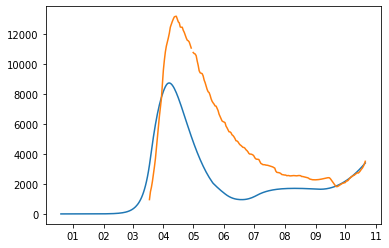

Deaths


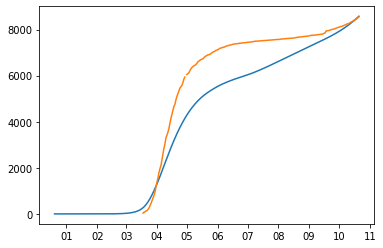

ICUs


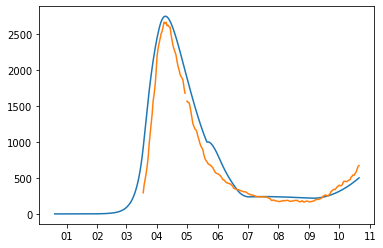

best_error: 5.976088901798664


5.976088901798664

In [55]:
%matplotlib inline
error_grad(v)

In [46]:
v

[86,
 4.0,
 1.1500674843132932,
 0.9167464969507519,
 0.3172592009287859,
 0.05127780756604089,
 0.5485413278685041,
 0.09666047198529543,
 0.9641282174235299,
 1.3385486523912138,
 0.5,
 2.0,
 1.2403213647998759,
 15]